In [1]:
#Primarily, pre-define the whole network which was just implemented on 2nd week assignment & some methods

import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np

def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

class examplenet(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear=nn.Linear(28*28, 10)
        self.softmax=nn.Softmax()

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear(x)
        x = self.softmax(x)

        return x

model = examplenet()

#If we wanna revise your hyperparameters, we could just do that.
learning_rate = 1e-3
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [2]:
#1 Tensorboard Setup
from torch.utils.tensorboard import SummaryWriter

# original directory of tensorboard is 'runs' but we could revise this directory such as 'runs/experiment1'
# If you wanna make many experiments with one model, making such directories is strongly recommended since you have to make lots of tensorboard afterward.
writer = SummaryWriter('runs/experiment1')

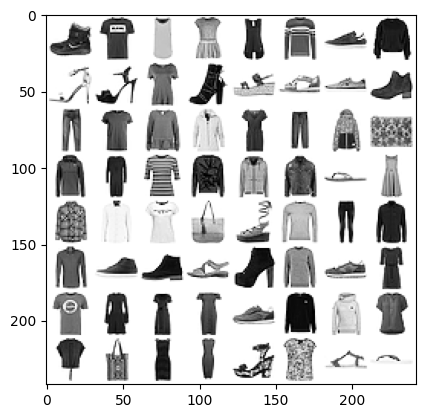

In [3]:
# +) Image Uploading

dataiter = iter(train_dataloader)
images, labels = next(dataiter)

img_grid = torchvision.utils.make_grid(images)

matplotlib_imshow(img_grid, one_channel=True)

writer.add_image('Images on Dataset', img_grid)

In [4]:
writer.add_graph(model, images)
writer.close()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1501: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return forward_call(*args, **kwargs)
<ipython-input-1-d0f4ea1989d4>:52: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.softmax(x)


In [5]:
#3 Track the loss of model on Tensorboard

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):

        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

            writer.add_scalar('training loss',
                            loss,
                            (batch + 1) * len(X))
            #We could add the scalar of loss so that we could finally visulaize the loss plot on tensorboard

def test_loop(dataloader, model, loss_fn):

    model.eval() #test mode
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0



    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss, optimizer)
    test_loop(test_dataloader, model, loss)
print("Done!")

Epoch 1
-------------------------------
loss: 2.240906  [   64/60000]


<ipython-input-1-d0f4ea1989d4>:52: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.softmax(x)


loss: 2.232449  [ 6464/60000]
loss: 2.204395  [12864/60000]
loss: 2.180195  [19264/60000]
loss: 2.200208  [25664/60000]
loss: 2.204303  [32064/60000]
loss: 2.194729  [38464/60000]
loss: 2.186509  [44864/60000]
loss: 2.192734  [51264/60000]
loss: 2.173558  [57664/60000]
Test Error: 
 Accuracy: 39.7%, Avg loss: 2.165968 

Epoch 2
-------------------------------
loss: 2.211955  [   64/60000]
loss: 2.198744  [ 6464/60000]
loss: 2.172600  [12864/60000]
loss: 2.153408  [19264/60000]
loss: 2.159746  [25664/60000]
loss: 2.171525  [32064/60000]
loss: 2.157144  [38464/60000]
loss: 2.150069  [44864/60000]
loss: 2.155421  [51264/60000]
loss: 2.132798  [57664/60000]
Test Error: 
 Accuracy: 45.7%, Avg loss: 2.129312 

Epoch 3
-------------------------------
loss: 2.175030  [   64/60000]
loss: 2.161960  [ 6464/60000]
loss: 2.139265  [12864/60000]
loss: 2.123851  [19264/60000]
loss: 2.117070  [25664/60000]
loss: 2.131487  [32064/60000]
loss: 2.113059  [38464/60000]
loss: 2.106936  [44864/60000]
loss: 

In [6]:
#Install wandb
!pip install wandb

In [7]:
import wandb

wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [8]:
run = wandb.init(

    project="project 1",

    #Make configuration
    #In deep learning, configuration means the set of hyperparameters. You could include something that we should determine such as epochs, learning_rate, weight decay, batch size and seed etc.
    #As you know, if we wanna obtain same result through randomized & augmented network, we have to fix the seed !
    config={
        "learning_rate": 0.01,
        "epochs": 10,
    },
    reinit=True
    )

wandb.watch(model)

## 처음엔 project 1으로 하다가 중간에 오류가 난 이후로 계속 되지 않아 project 2로 바꿔서 실행했습니다

wandb: Currently logged in as: wnsgur2801. Use `wandb login --relogin` to force relogin


[]

In [9]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):

        pred = model(X)
        loss = loss_fn(pred, y)


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

            #Revision of your training code as below:
            wandb.log({ "Training_loss": loss}) #You can record your log here

def test_loop(dataloader, model, loss_fn):

    model.eval() #test mode
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0



    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


In [ ]:
#Then, enjoy your wandb!
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss, optimizer)
    test_loop(test_dataloader, model, loss)
    #pytorch method for saving model's weight
    torch.save(model.state_dict(), '/content/model.pth')
    # Save as artifact for version control.
    artifact = wandb.Artifact('model', type='model')
    artifact.add_file('/content/model.pth')
print("Done!")

Epoch 1
-------------------------------
loss: 2.297397  [   64/60000]


<ipython-input-24-d0f4ea1989d4>:52: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.softmax(x)


loss: 2.297122  [ 6464/60000]
loss: 2.292145  [12864/60000]
loss: 2.296216  [19264/60000]
loss: 2.293369  [25664/60000]
loss: 2.285381  [32064/60000]
loss: 2.288487  [38464/60000]
loss: 2.280740  [44864/60000]
loss: 2.279781  [51264/60000]
loss: 2.280155  [57664/60000]
Test Error: 
 Accuracy: 29.1%, Avg loss: 2.276250 

Epoch 2
-------------------------------
loss: 2.274332  [   64/60000]
loss: 2.274654  [ 6464/60000]
loss: 2.263074  [12864/60000]
loss: 2.272105  [19264/60000]
loss: 2.260317  [25664/60000]
loss: 2.247949  [32064/60000]
loss: 2.255442  [38464/60000]
loss: 2.238414  [44864/60000]
loss: 2.251369  [51264/60000]
loss: 2.241504  [57664/60000]
Test Error: 
 Accuracy: 46.9%, Avg loss: 2.236715 

Epoch 3
-------------------------------
loss: 2.240120  [   64/60000]
loss: 2.235312  [ 6464/60000]
loss: 2.213759  [12864/60000]
loss: 2.233956  [19264/60000]
loss: 2.194367  [25664/60000]
loss: 2.187650  [32064/60000]
loss: 2.200787  [38464/60000]
loss: 2.173327  [44864/60000]
loss: 

In [16]:
%%capture

!pip install -q --upgrade wandb
!pip install torchtext==0.10.1

import torch
from torch import nn
import torch.nn.functional as F
from torchtext.legacy import data
from torch.autograd import Variable
from torchtext.legacy import datasets
from torchtext.vocab import Vectors, GloVe

# torch legacy가 계속 실행이 안되네요...

ModuleNotFoundError: ignored

In [ ]:
import os
import wandb

# Paste your api key here
os.environ["WANDB_API_KEY"] = '...'

# Feel free to change these and experiment !!
config = wandb.config
config.learning_rate = 2e-5
config.batch_size = 32
config.output_size = 2
config.hidden_size = 256
config.embedding_length = 300
config.epochs = 10

Error: ignored

In [18]:
rnn = nn.RNN(10, 20, 2)
input = torch.randn(5, 3, 10)
h0 = torch.randn(2, 3, 20)
output, hn = rnn(input, h0)

In [17]:
lstm = nn.LSTM(10, 20, 2)
input = torch.randn(5, 3, 10)
h0 = torch.randn(2, 3, 20)
c0 = torch.randn(2, 3, 20)
output, (hn, cn) = lstm(input, (h0, c0))

In [19]:
def load_dataset(test_sen=None):

    tokenize = lambda x: x.split()
    TEXT = data.Field(sequential=True, tokenize=tokenize, lower=True, include_lengths=True, batch_first=True, fix_length=200)
    LABEL = data.LabelField()
    train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)
    TEXT.build_vocab(train_data, vectors=GloVe(name='6B', dim=300))
    LABEL.build_vocab(train_data)

    word_embeddings = TEXT.vocab.vectors #Word Embedding means the vectorization version of NLP since computer couldn't understand the language literally. We should convert NL into some numbers, which must be some tensors

    train_data, valid_data = train_data.split()
    train_iter, valid_iter, test_iter = data.BucketIterator.splits((train_data, valid_data, test_data),
                                                                   batch_size=32,
                                                                   sort_key=lambda x: len(x.text),
                                                                   repeat=False, shuffle=True)

    vocab_size = len(TEXT.vocab)

    return TEXT, vocab_size, word_embeddings, train_iter, valid_iter, test_iter

TEXT, vocab_size, word_embeddings, train_iter, valid_iter, test_iter = load_dataset()

NameError: ignored